# Install Libraries

In [ ]:
!pip install transformers[torch]
!pip install datasets
!pip install sentence_transformers
!pip install numba
!pip install evaluate
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from numba import cuda
import pandas as pd
import numpy as np
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import create_optimizer
from tqdm import tqdm
import gc
from transformers import get_scheduler
from torch.optim import AdamW
import torch.cuda
from google.colab import runtime
import evaluate

# Preprocessing


In [ ]:
# Mount drive
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# Import and visualize data
data = pd.read_csv('/content/Embedded_Lies_for_ML.csv', sep = ';', encoding = 'UTF-8')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (2084, 4)


,Participant_id,Stand_num_embedded_lies,Condition,Event
0,660687a02630547fb296d754,0.192708,0,I was in a city nearby my hometown. I was goin...
1,65391353897d68dd53a067da,0.204082,0,It was a 5 year relationship and we were very ...
2,615b2ee8616d1b05551794ee,0.705882,0,It was on the 14th of February when I walked i...
3,616dc201c0b58a25890f4b94,0.545455,0,My partner and I were in a long distance relat...
4,5b6034ba0ced0a00017ba9b9,0.166667,0,we had to plan a celebration for our departmen...


In [ ]:
#data['Condition'] = data['Condition'].map({0:'Truthful', 1:'Deceptive'})

In [ ]:
# Create a smaller version of the dataset to check if the algo works
id = data['Participant_id'].head(10)
data = data[data['Participant_id'].isin(id)]
print(data.shape)
print(data)

(20, 4)
                Participant_id  Stand_num_embedded_lies  Condition  \
0     660687a02630547fb296d754                 0.192708          0   
1     65391353897d68dd53a067da                 0.204082          0   
2     615b2ee8616d1b05551794ee                 0.705882          0   
3     616dc201c0b58a25890f4b94                 0.545455          0   
4     5b6034ba0ced0a00017ba9b9                 0.166667          0   
5     5f4e0edcc541ccaf7a8f11c4                 0.083333          0   
6     60e807c17adbb05b6799a83e                 0.176080          0   
7     616dd4121bdb418e5cbb09a5                 0.171429          0   
8     6613f2bcc9eb1d833c3c107c                 0.464286          0   
9     60d336e24fbd4089351d3785                 0.087912          0   
1042  660687a02630547fb296d754                 0.192708          1   
1043  65391353897d68dd53a067da                 0.204082          1   
1044  615b2ee8616d1b05551794ee                 0.705882          1   
1045  616dc2

In [ ]:
# Rename columns for HF training
data.rename(columns = {'Condition':'labels', 'Event':'text'}, inplace = True)

In [ ]:
# Function for cross validation

from sklearn.model_selection import train_test_split, GroupKFold
import pandas as pd
import numpy as np

def create_dataset(data, seed=42, cv=5):
    np.random.seed(seed)

    # Initialize train and test dictionaries
    train = {f'split_{i+1}': [] for i in range(cv)}
    test = {f'split_{i+1}': [] for i in range(cv)}

    # Get participant IDs as groups
    participant_ids = data['Participant_id'].unique()

    # Cross-validation using GroupKFold
    group_kfold = GroupKFold(n_splits=cv)

    for i, (train_idx, test_idx) in enumerate(group_kfold.split(data, groups=data['Participant_id'])):
      train_participants = participant_ids[np.intersect1d(train_idx, np.arange(len(participant_ids)))]
      test_participants = participant_ids[np.intersect1d(test_idx, np.arange(len(participant_ids)))]

      # Create train and test sets based on Participant_id
      train[f'split_{i+1}'] = data[data['Participant_id'].isin(train_participants)]
      test[f'split_{i+1}'] = data[data['Participant_id'].isin(test_participants)]

    return train, test

In [ ]:
# Preprocess function
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
# Define metrics for evaluating model performance
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# DistilBERT model


In [ ]:
# Define parameters
seed=42
np.random.seed(seed)
collect_result={}
numcv=5
num_epochs = 3
dataset = data
results={}
predictions={}
labels={}

# Train-test split for cross validation
train, test = create_dataset(data, seed=seed, cv=numcv)

# Loop over each split in the cross-validation
for sp in tqdm(train.keys()):

  data_train = Dataset.from_pandas(train[sp])
  data_test = Dataset.from_pandas(test[sp])

  # Load the pre-trained model and tokenizer
  checkpoint = f"distilbert-base-uncased"
  tokenizer = AutoTokenizer.from_pretrained(checkpoint)
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

  # Apply preprocessing to the datasets
  tok_data_train = data_train.map(preprocess_function, batched=True)
  tok_data_test = data_test.map(preprocess_function, batched=True)

  # Define the data collator for padding and batching
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Set training arguments
  training_args = TrainingArguments(
      output_dir=f"/content/gdrive/MyDrive/PhD project/Embedded Lies/distilBERT",
      learning_rate=5e-5,
      per_device_train_batch_size=32,
      per_device_eval_batch_size=32,
      weight_decay=0.01,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      save_total_limit=3,
      num_train_epochs=num_epochs,
      load_best_model_at_end=True,
      fp16=False,
      push_to_hub=False,
      logging_strategy="steps",
      logging_steps=10,
      report_to="tensorboard"
  )


  # Initialize the trainer, then train the model on current split
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tok_data_train,
      eval_dataset = tok_data_test,
      tokenizer=tokenizer,
      data_collator=data_collator,
      compute_metrics=compute_metrics
  )

  trainer.train()
  trainer.evaluate()

  # Generate predictions
  predictions = trainer.predict(tok_data_test)
  predictions = np.argmax(predictions.predictions, axis=1)

  # Collect results in a DF for the current split
  collect_result[sp]=pd.DataFrame.from_dict({
      "Participant_id": test[sp]["Participant_id"],
      "Split": sp,
      "Prediction": predictions,
      "Label": np.array(test[sp]["labels"])})
  collect_result[sp]['Correct_predictions'] = collect_result[sp]['Prediction'] == collect_result[sp]['Label']

  # Clear the model from memory after each split
  del model
  del trainer
  torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1664 [00:00<?, ? examples/s]

Map:   0%|          | 0/420 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-71c94c6e742a>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.697200,0.692703,0.500000
2,0.681900,0.665143,0.621429
3,0.606700,0.665551,0.638095


 20%|██        | 1/5 [03:55<15:42, 235.74s/it]Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1666 [00:00<?, ? examples/s]

Map:   0%|          | 0/418 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-71c94c6e742a>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.695400,0.682617,0.593301
2,0.662800,0.648128,0.614833
3,0.526200,0.650249,0.617225


 40%|████      | 2/5 [07:39<11:26, 228.94s/it]Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1670 [00:00<?, ? examples/s]

Map:   0%|          | 0/414 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-71c94c6e742a>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.708100,0.692587,0.500000
2,0.650700,0.663282,0.601449
3,0.550400,0.690762,0.601449


 60%|██████    | 3/5 [11:28<07:37, 228.99s/it]Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1668 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-71c94c6e742a>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.683700,0.681015,0.608173
2,0.662200,0.654278,0.610577
3,0.536100,0.674329,0.627404


 80%|████████  | 4/5 [15:05<03:44, 224.16s/it]Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1668 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-37-71c94c6e742a>:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.691700,0.689267,0.548077
2,0.647700,0.685564,0.562500
3,0.574500,0.686144,0.591346


100%|██████████| 5/5 [18:49<00:00, 225.84s/it]


In [ ]:
# Display the results in a pandas dataframe
results = pd.concat(collect_result.values(), keys=collect_result.keys())
results = results.droplevel(1)
results

,Participant_id,Split,Prediction,Label,Correct_predictions
split_1,65391353897d68dd53a067da,split_1,0,0,True
split_1,60e807c17adbb05b6799a83e,split_1,1,0,False
split_1,5ef09df28c610f5ffa1601c9,split_1,0,0,True
split_1,6126a2b75731d7dcfefa4cc2,split_1,0,0,True
split_1,6133d6ceda5d8d0022d8b108,split_1,0,0,True
...,...,...,...,...,...
split_5,661abe5c2de36bfb2ae592dc,split_5,1,1,True
split_5,5d376974a552fb00165010f1,split_5,1,1,True
split_5,611d14372f0789675dc47b76,split_5,1,1,True
split_5,6171aa5fff416f8783493856,split_5,0,1,False


In [ ]:
results[results]

In [ ]:
results.to_csv('/content/5cv_distilBERT_embedded_lies.csv', sep=';', index=False)

In [ ]:
import pandas as pd
results = pd.read_csv('/content/5cv_distilBERT_embedded_lies.csv', sep=';')

In [ ]:
results.head()

,Participant_id,Split,Prediction,Label,Correct_predictions
0,65391353897d68dd53a067da,split_1,0,0,True
1,60e807c17adbb05b6799a83e,split_1,1,0,False
2,5ef09df28c610f5ffa1601c9,split_1,0,0,True
3,6126a2b75731d7dcfefa4cc2,split_1,0,0,True
4,6133d6ceda5d8d0022d8b108,split_1,0,0,True


In [ ]:
deceptive = results[results['Label']==1]
truthful = results[results['Label']==0]

print(f"deceptive recall: {deceptive['Correct_predictions'].sum()/len(deceptive)}")
print(f"truthful recall: {truthful['Correct_predictions'].sum()/len(truthful)}")

deceptive recall: 0.6938579654510557
truthful recall: 0.510556621880998


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Placeholder for storing scores for each split
scores_per_split = []
accuracy_per_split = []

# Unique splits
unique_splits = results['Split'].unique()

# Iterate through each split
for split in unique_splits:
    split_data = results[results['Split'] == split]

    # Compute classification report for the current split
    report = classification_report(
        split_data['Label'],
        split_data['Prediction'],
        target_names=['Truthful', 'Deceptive'],
        output_dict=True
    )

    # Append metrics for this split
    scores_per_split.append({
        "Truthful_precision": report['Truthful']['precision'],
        "Truthful_recall": report['Truthful']['recall'],
        "Truthful_f1": report['Truthful']['f1-score'],
        "Deceptive_precision": report['Deceptive']['precision'],
        "Deceptive_recall": report['Deceptive']['recall'],
        "Deceptive_f1": report['Deceptive']['f1-score'],
        "macro_precision": report['macro avg']['precision'],
        "macro_recall": report['macro avg']['recall'],
        "macro_f1": report['macro avg']['f1-score'],
        "weighted_precision": report['weighted avg']['precision'],
        "weighted_recall": report['weighted avg']['recall'],
        "weighted_f1": report['weighted avg']['f1-score'],
        "accuracy": report['accuracy']
    })
    accuracy_per_split.append(report['accuracy'])

# Convert scores to a DataFrame for easier averaging
scores_df = pd.DataFrame(scores_per_split)

# Compute average and standard deviation for each metric
average_scores = scores_df.mean()
std_scores = scores_df.std()

# Format output as a summary table
summary_table = pd.DataFrame({
    "Metric": average_scores.index,
    "Average": average_scores.values,
    "Standard Deviation": std_scores.values
})

# Display average classification report with standard deviation
print("\nAverage Classification Report with Standard Deviation:")
print("Label           Precision       Recall          F1-score")
print("=" * 60)
for label in ["Truthful", "Deceptive", "macro", "weighted"]:
    precision_avg = average_scores[f"{label}_precision"]
    precision_std = std_scores[f"{label}_precision"]
    recall_avg = average_scores[f"{label}_recall"]
    recall_std = std_scores[f"{label}_recall"]
    f1_avg = average_scores[f"{label}_f1"]
    f1_std = std_scores[f"{label}_f1"]
    print(
        f"{label:<15} {precision_avg:.3f} (±{precision_std:.3f})  "
        f"{recall_avg:.3f} (±{recall_std:.3f})  "
        f"{f1_avg:.3f} (±{f1_std:.3f})"
    )

# Print overall averaged metrics
accuracy_avg = np.mean(accuracy_per_split)
accuracy_std = np.std(accuracy_per_split)
print(f"Averaged accuracy: {accuracy_avg:.3f} (±{accuracy_std:.3f})")


Average Classification Report with Standard Deviation:
Label           Precision       Recall          F1-score
Truthful        0.636 (±0.046)  0.510 (±0.187)  0.547 (±0.100)
Deceptive       0.598 (±0.051)  0.694 (±0.158)  0.629 (±0.053)
macro           0.617 (±0.024)  0.602 (±0.023)  0.588 (±0.033)
weighted        0.617 (±0.024)  0.602 (±0.023)  0.588 (±0.033)
Averaged accuracy: 0.602 (±0.021)


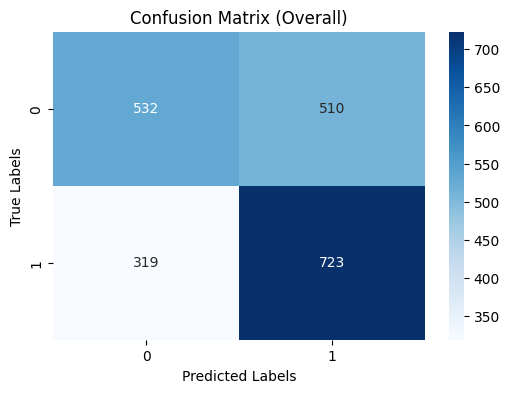

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(results['Label'], results['Prediction'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues') #, xticklabels=['Deceptive', 'Truthful'], yticklabels=['Deceptive', 'Truthful'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Overall)')
plt.show()